# Contrail Detection - Part I - UNet
This is part 1 in a short series of notebooks that will aim to tackle the Kaggle competition of predicting the presence of contrails in infrared image bands. For other posts on this topic, please visit the original data science project page.

## Introduction
It's a clear blue sky, and you look up at and see a plane flying overhead. Not only that, but you see a thin line following it. This is a **contrail**. Although it might seem they dissipate and disappear from the naked eye soon after, these actually linger in the atmosphere for far longer. Contrails occur when small exhaust particles from the aircraft's engine come into contact to the cold air in the atmosphere. Ice crystals from around these many particles, until they become large enough to see with the naked eye. How long these contrails are visible depends on the temperature and humidity of the air. Some of these last long enough that they appear to be clouds on their own.

### Why detection?
Unfortunately, although they look innocuous, these contrail emissions measurably contribute to climate change. During nighttime, the Earth naturally radiates heat as it cools down. **However, the many contrails that are present in the atmosphere can mitigate and prevent this effect, eventually trapping heat and causing unnatural warming**. It has been shown that using biofuels can reduce contrail formation by a large amount. In order to produce more solid research and confirm the extent of which these contrails are contributing to global warming, scientists need a quick and reliable way of detecting them in the atmosphere. These include contrails that are not visible to the naked eye anymore.

### Kaggle competition details
Kaggle has a competition surrounding this topic. Participants are given square images of the atmosphere that may or may not contain contrails, and are asked to produce classify **by the pixel** whether said pixel contains part of a contrail. Most notably, each sample consists a time-series of images, in various **infrared** bands. This means that normally these contrails will not be visible to the naked eye. The time-series of images are provided because these are the images that are given to the original human classifiers. Due to their structure, contrails look and move differently than regular clouds.

## Import Packages
We will go over the actual data and model we will use in a bit, but first, we need to import everything we will need. The core libraries we will use are PyTorch 2.2 and PyTorch Lightning. The latter will streamline the training and fitting process (similar to TensorFlow's `.fit()` method). PyTorch has been built on a CUDA 12.1 system. Other CUDA versions might force a downgrade to PyTorch's versions, but the core functionalities should remain the same.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Optional
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchinfo

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models.feature_extraction import create_feature_extractor

from torchmetrics import Dice, MeanMetric
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.functional import dice

import pytorch_lightning as pl
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

pl.seed_everything(8128)

ROOT = '../'
DATA_DIR = os.path.join(ROOT, 'data', 'google-research-identify-contrails-reduce-global-warming', 'validation')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Seed set to 8128


## Data Overview
As mentioned before, the data consists of many sets of time-series images. Each set comprises of the same 256 by 256 patch of the sky over a time period. We have one central *target* time point (the ground truth contrail locations are given with respect to this time step), 4 time steps before, and 3 time steps after, for a total of 8 total time steps. Instead of visual RGB images, 8 separate bands in the IR range are given. Along with that, a single matrix of `human_pixel_masks.npy` corresponds to the ground truth contrails for the middle time point. Each pixel is either a 0 or 1, corresponding to "no contrail" or "contrail".

The training data consists of more than 20 thousand samples, while validation has just under 2 thousand. Due to the sheer size of the training set, **we will only work off of the validation set, which is around 33 GB in size.**

To download just the validation, first ensure you have at least 60 GB of free space. Then, head to the [competition data download page](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data?select=validation) (accept the competition rules if necessary) and download the zip folder `validation.zip`. Then, unzip the contents to `/data/google-research-identify-contrails-reduce-global-warming/validation` and you should be all set. Delete the zip file after extraction if you want to free up some space.

### About the IR bands
Infrared is a band of light that is of longer wavelength than the visible spectrum. Infrared is very sensitive to heat, and so this is why you see infrared being used in thermal imaging cameras. When projecting IR into the atmosphere, different exposure levels will be generated. Each "band" of infrared exposes the atmosphere to particular wavelength, and individual images are generated in this way. Information on what each band's wavelength is and what each is used for can be found [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html). Our data consists of **bands 8 through 16** for each sample. For example, band 8 is used for identifying jet streams, while band 16 is used for carbon dioxide detection e.g. volcanic ash. During analysis and processing, these bands can be analyzed directly, but it is difficult to interpret these values for the layman. For this reason, when showing images of note, we will be using **false color images**. 

False color images are images where the colors are artificially calculated from non-visible light images. While the images will be in color, these do not represent the actual color in real life. Using specific band values, along with minor transformations, different kinds of color images can be produced. Because we need to visualize contrails, which are similar to cirrus clouds, we will use the **ash** color scheme (on page 7 in [this document](https://eumetrain.org/sites/default/files/2020-05/RGB_recipes.pdf). For this, we need images taken with $8.7\mu m$, $10.8\mu m$, and $12\mu m$. These correspond closest to bands 11, 14, and 15. According to the document, the following will be our RGB values:

$$
\begin{aligned}
    R &= b_{15} - b_{14} \\
    G &= b_{14} - b_{13} \\
    B &= b_{14}
\end{aligned}
$$

In addition, the "Range" columns signify how to rescale the ensuing values given the minimum and maximum. For example, for the red and green channels, the minimum and maximum should be assumed to be $-4$ and $2$ and rescaled accordingly.

### False Color Example + Contrail Mask
Using the rules, we can easily convert a sample image into a false color image. This will help us more easily visualize the contrails, and their masks.

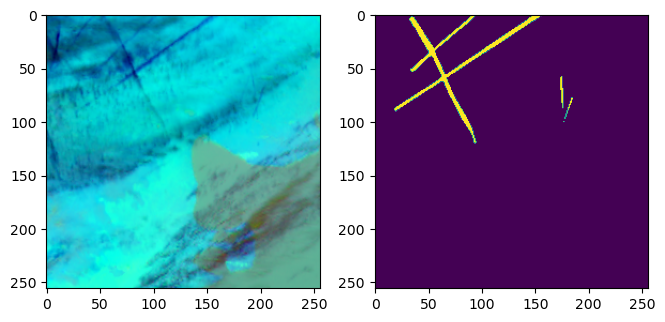

In [2]:
def get_contrail_image_mask(sample_id):
    # Read the 3 bands we need, and extract the target time step
    band_11 = np.load(os.path.join(DATA_DIR, sample_id, 'band_11.npy'))[:, :, 5]
    band_14 = np.load(os.path.join(DATA_DIR, sample_id, 'band_14.npy'))[:, :, 5]
    band_15 = np.load(os.path.join(DATA_DIR, sample_id, 'band_15.npy'))[:, :, 5]
    
    # Let's save the image size, will be useful later
    IMAGE_SIZE = band_11.shape[0]
    
    # Calculate R, G, and B channels, with the scaling.
    # Clip to between 0 and 1 so that we don't get invalid values
    red = ((band_15 - band_14 + 4) / (2 + 4)).clip(0, 1)
    green = ((band_14 - band_11 + 4) / (5 + 4)).clip(0, 1)
    blue = ((band_11 - 243) / (303 - 243)).clip(0, 1)
    # Stack them correctly, and transpose so that the channels are list
    image = np.stack((red, green, blue), axis=0).transpose((1, 2, 0))
    
    # Now read the mask, it has an extra singleton channel dimension at the end,
    # so get rid of that.
    mask = np.load(os.path.join(DATA_DIR, sample_id, 'human_pixel_masks.npy')).squeeze()
    
    return image, mask

image, mask = get_contrail_image_mask('82272245413161715')
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(image)
ax = plt.subplot(1, 3, 2)
ax.imshow(mask)
plt.savefig('./contrail_example.png')
plt.show()

With the false color image and the mask side-by-side, the exact location of the contrail can be clearly seen. Notice other "wispy" features in the color image which aren't classified as contrails. These are most likely cirrus clouds or other features. It's this combination that generally makes it a bit tough for scientists to pick these out by hand, and why a time series of images are valuable.

Even later, this code block will serve as our "preprocessing" of the data. Each sample will be converted to a false color image before being fed through our network.

### Data characteristics
Even though the preprocessing seems relatively minor, we still should examine the data for general properties. For example, how many images actually contain contrails?

In [3]:
# First some basic counts...
samples = next(os.walk(DATA_DIR))[1]
num_samples = len(samples)
print(f'There are {num_samples} different images.')
IMAGE_SIZE = 256

# Next, we'll count how many images have contrails at all,
# and also, what percentage of pixels are contrails, and what aren't.
no_contrail_images = 0
total_con_pixels = 0
for sample in samples:
    mask = np.load(os.path.join(DATA_DIR, sample, 'human_pixel_masks.npy')).squeeze()
    # Since they're all 0 and 1, summing will tell us how many contrail pixels there are.
    contrail_pixels = np.sum(mask)
    if contrail_pixels == 0:
        no_contrail_images += 1
    total_con_pixels += contrail_pixels

print(f'There are {no_contrail_images} images ({no_contrail_images / num_samples * 100:2.2f}%) without ANY contrails.')
print(f'There are {total_con_pixels} ({total_con_pixels / (num_samples * IMAGE_SIZE * IMAGE_SIZE) * 100:2.2f}%) pixels that are contrails.')

There are 1856 different images.
There are 1304 images (70.26%) without ANY contrails.
There are 220446 (0.18%) pixels that are contrails.


These are interesting metrics. When all is said and done, **only about 30%** of the images contain any contrails at all. Even more extreme, more than **99.8%** of pixels don't have contrails. These numbers are important, because these will influence how we treat eventual model performance metrics. Using pure accuracy, the model will be very heavily skewed towards predicting no contrails anywhere. Doing so will lead to near-perfect accuracy. 

This tells us that accuracy is in fact a very poor metric to evaluate model performance. Expectedly, Kaggle themselves do not use this as performance indicators. Instead, they use the **Dice coefficient**.

#### Dice coefficient
In general, the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) is a measure of similarity between two sets. In our case, the "sets" is the set of predictions and the set of ground truth masks. Since we have boolean data, we can write in the form of true positives, false positives, and false negatives:

$$
D = \frac{2TP}{2TP + FP + FN}
$$

With our earlier example, if a model does not predict a contrail anywhere, then we have 0 true positives, and thus the Dice coefficient evaluates to **zero**. This is much more indicative of the model performance in this case, rather than the 99.8% accuracy. If we were to instead predict contrails everywhere, then we the metric would be:

$$
D = \frac{2TP}{2TP + FP + FN} = \frac{2(220\,446)}{2(220\,446) + \big(1856(256)^2 - 220\,446\big) + 0} = \boxed{0.0036}
$$

which is also indicative of poor performance. Therefore, the Dice coefficient is vastly superior to the traditional accuracy in this case. Even more, although we do have classification, the network we build will have to predict each pixel individually, rather than the image as a whole.


## Building the network
Speaking of the network, this isn't quite the usual image classification model that is widely used everywhere. Instead, this is **image segmentation**. The main reason is that the solution to this problem differs from the conventional classification:

- _Image classification_ - Given a single image, classify the **entire** image to a class.
- _Image segmentation_ - Given a single image, classify **each pixel** to a class.

What are some applications of image segmentation? They are widely used in the medical imaging field, such as detecting cancerous regions in tissue. They can also be used in pedestrian and brake light detection for autonomous vehicle systems. In the end, it is still an important enough subfield that much research has gone into this topic.

For our use case, we will extract the _target_ time step, and we will be predicting each pixel as either containing a contrail, or not. At the core, this is classic binary classification, just performed at the pixel level instead of the image level.

One important consequence of predicting each pixel is that **the size of both the input and output will be the same.** In practice, if our input image size is 256 by 256 pixels, then our output will also be 256 x 256 pixels. We classify all the pixels all at once given a single image.

### UNet
The different classification task that this problem requires means a different model architecture. Usually, the likes of ResNet and EfficientNet can be used as pre-trained image classification networks. But instead, we'll use a type of network called a **UNet**.

A UNet is specifically designed for image segmentation. The UNet is split into two parts: the encoder and the decoder. The encoder has the original image as input, and continually downscales the image to smaller and smaller sizes, not unlike a traditional classification. However, instead of a classification layer, the decoder is attached instead. The decoder retrieves the encoder output, and contiually **upsamples** each layer, until the final output which will be the same size as the input image. Crucially, **the values of intermediate encoding output are used as input to each layer in the decoder.** This is the core reason why UNets are very powerful. This structure also leads to the network graph being in the shape of a "U", hence UNet. The image below is extracted from the [original UNet paper](https://arxiv.org/pdf/1505.04597.pdf).

![unet](unet.png)

Commonly, the encoder of the UNet is generally a pre-trained image classification network, such as ResNet or MobileNet.

### Converting TensorFlow to PyTorch
TensorFlow has a [great tutorial](https://www.tensorflow.org/tutorials/images/segmentation) on image segmentation and how to build the UNet, using MobileNet as a backend encoder. However, we are in PyTorch, so we have some work to do converting it. We can simply download the MobileNet model from `torch.hub`, but other than that, we have to two key parts we need to implement:

1. **pix2pix block** - This is the layer block that is responsible for upsampling and increasing the resolution of the image. It is a core part of the decoder than is absolutely necessary.
2. **Intermediate connections of MobileNet to the decoder** - We also need to extract the correct layers from MobileNet, and establish connections from that to the corresponding layers in the decoder. These are the gray arrows in the UNet picture above.


#### Pix2pix
This is the simpler of the two. TensorFlow's version of the pix2pix upsample method is defined [here](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) as part of the `upsample()` method. At its core, pix2pix is just 4 layers put together: a transposed 2D convolution, batch normalization, dropout, and ReLU activation. It is fairly straightforward to define these in this order. This version perfectly scales up the image by a factor of 2. Since our image size is a power of 2 (256), this works out nicely. All we need are the input and output channels, and the size of the kernel. Like the original, we should also initialize the weights of the transpose layer with a mean of 0 and standard deviation of 0.02.

In [4]:
class Pix2PixUpsample(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size):
        super().__init__()
        
        self.conv2d = nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride=2, padding=1, bias=False)
        # Initialize weights with mean 0 and standard deviation 0.02
        nn.init.normal_(self.conv2d.weight, mean=0, std=0.02)
        
        self.model = nn.Sequential(
            self.conv2d, 
            nn.BatchNorm2d(out_chan),
            nn.Dropout(0.5),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)
        

Passing a random tensor through, you can see the layer block in action. It perfectly scales up the input by a factor of 2, given a kernel size of 4.

In [5]:
x = torch.rand((4, 30, 64, 64))
print('Shape before:', x.shape)
pix2pix = Pix2PixUpsample(30, 60, kernel_size=4)
print('Shape after:', pix2pix(x).shape)

Shape before: torch.Size([4, 30, 64, 64])
Shape after: torch.Size([4, 60, 128, 128])


#### Extracting Intermediate MobileNet Features
This is trickier, because there are strict requirements in which features we extract. Extracting the wrong features will lead to shape mismatches when we concatenate them during decoder output. According to TensorFlow, the following are the layer names and their corresponding sizes.

```python
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
```
We'll need to examine PyTorch's MobileNet to see which layers we need. However, by default, PyTorch does not show what the output shapes are for each layer. For that, we use the `torchinfo` package. TensorFlow's input was actually half the size of our input (128 by 128), and the corresponding chosen layers reduced the image by a factor 2, 4, and so on. So in our case, we need to search for layers whose output shapes are 128 x 128, 64 x 64, etc.

Finally, once we find the first one, it is simple to find the rest, because of the indexing present in the numbering.

In [6]:
mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
batch_size = 8
torchinfo.summary(mobilenet, input_size=(batch_size, 3, 256, 256), depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [8, 1000]                 --
├─Sequential: 1-1                                  [8, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [8, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                            [8, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                       [8, 32, 128, 128]         64
│    │    └─ReLU6: 3-3                             [8, 32, 128, 128]         --
│    └─InvertedResidual: 2-2                       [8, 16, 128, 128]         --
│    │    └─Sequential: 3-4                        [8, 16, 128, 128]         --
│    │    │    └─Conv2dNormActivation: 4-1         [8, 32, 128, 128]         352
│    │    │    └─Conv2d: 4-2                       [8, 16, 128, 128]         512
│    │    │    └─BatchNorm2d: 4-3                  [8, 16, 128, 128]         32
│    └─InvertedResidual: 2-3    

There are many layers with an output of 128 x 128. Which one do we choose? A quick look at the **second line** of the UNet output graph on TensorFlow's tutorial page, we see that we need the output with **96 channels** i.e. 96 x 128 x 128. Therefore, it is the `Conv2dNormActivation` of the second `InvertedResidual` block. As for the actual layer name, we have to peek into the `mobilenet` object.

In [7]:
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The layer names are in the parentheses preceding each line. The full layer name comprises a concatenation of the individual names separated by periods e.g. for the first extraction layer, we have `features.2.conv.0`. Using the original indices, we can get the other names as well:

- `features.4.conv.0`
- `features.7.conv.0`
- `features.14.conv.0`

For the final block, since we want the full projection, we have 2 at the end instead of 0: `features.17.conv.0`. Now that we have all the corresponding layer names, we can use the `create_feature_extractor` method to extract the values in these layers.

In [8]:
layers = {
    'features.2.conv.0': 'block_1',    # 128 x 128
    'features.4.conv.0': 'block_3',    # 64 x 64
    'features.7.conv.0': 'block_6',    # 32 x 32
    'features.14.conv.0': 'block_13',  # 16 x 16
    'features.17.conv.2': 'block_16'   # 8 x 8
}
encoder = create_feature_extractor(mobilenet, return_nodes=layers)

# Push a sample input and show the shapes for each layer...
x = torch.randn((4, 3, 256, 256)).to(DEVICE)
encoder_output = encoder(x)
for key, output in encoder_output.items():
    print(key, output.shape)

block_1 torch.Size([4, 96, 128, 128])
block_3 torch.Size([4, 144, 64, 64])
block_6 torch.Size([4, 192, 32, 32])
block_13 torch.Size([4, 576, 16, 16])
block_16 torch.Size([4, 320, 8, 8])


#### Decoder
For the decoder, we take the final projection encoder layer, and slowly upscale the image until it equals the input image size. Every time we upscale, we concatenate the corresponding output layer from the encoder, and we work our way on up.

The number of channels for each block is also important to note, as it will influence the sizes of the subsequent layers. For example, for the first `Pix2PixUpsample` layer, there will be **320** input channels (the number of channels in the final encoder layer). Let's say the first decoder layer will have 512 output channels.

For the second `Pix2PixUpsample`, we append the channels of the second to last encoder layer (576) to 512. In total, this is **1088**. In this way, we bulid the upsample stack. See below for the full list.

The number of output channels in the final upsample has to equal the number of classes we have. However, there shouldn't be any dropout or activation here, so it is a simple `Conv2dTranspose`.

In [9]:
up_stack = nn.ModuleList([
    Pix2PixUpsample(320, 512, 4),        # 8 x 8 ==> 16 x 16
    Pix2PixUpsample(576 + 512, 256, 4),  # 16 x 16 ==> 32 x 32
    Pix2PixUpsample(192 + 256, 128, 4),  # 32 x 32 ==> 64 x 64
    Pix2PixUpsample(144 + 128, 64, 4)    # 64 x 64 ==> 128 x 128
]).to(DEVICE)


# The final layer is just a simple transpose, with a single output channel.
last_conv = nn.ConvTranspose2d(in_channels=96 + 64, out_channels=1, kernel_size=4, stride=2, padding=1).to(DEVICE)

Now, during the forward step, we need to grab the encoder output, and for each layer in the up stack, we pass our actual encoder output, and concatenate the intermediate layer outputs before passing it to the next upsample layer, as follows:

In [10]:
def decode(encoder_output: dict):
    # Make a list version of the encoder output.
    # We call these "skip connections".
    skips = list(encoder_output.values())
    # Because we are going from the bottom to the top, we reverse the list,
    # and grab the last output as well (block 16).
    x = skips[-1]
    skips = skips[::-1][1:]
    
    # For each upsample layer block, we pass our current
    # values through it, and concatenate it with the corresponding
    # intermediate encoder output afterwards.
    for up, skip_connection in zip(up_stack, skips):
        x = up(x)
        x = torch.cat([x, skip_connection], dim=1)
    # Pass it through the final transpose layer
    x = last_conv(x)
    return x

print('Final encoder output:', encoder_output['block_16'].shape)
decoder_output = decode(encoder_output=encoder_output)
print('Decoder output:', decoder_output.shape)

Final encoder output: torch.Size([4, 320, 8, 8])
Decoder output: torch.Size([4, 1, 256, 256])


With that, you can see the final decoder output is the size we want: A single channel 256 by 256 image. Applying the sigmoid activation to this layer will lead to a probability being assigned to each pixel. This is the probability that this pixel contains a contrail. 

In the following sections, we will create the datasets and dataloaders, along with fully defining the UNet model, where we put all the methods above all together. To do this seamlessly, we will [PyTorch Lightning](https://lightning.ai), which eases the training workflow.

## Creating the DataModule
Our actual dataset object will extend from `torch.utils.data.Dataset`, but our DataLoader will be part of a larger `LightningDataModule` class. This latter class allows us to define the training, validation, and testing dataloaders in one location. PyTorch Lightning will be smart enough to load the correct one during actual training and validation.

### Dataset
For a `Dataset` class definition, we need 3 methods: `__init__`, `__len__`, and `__getitem__`. The latter two return the length of the dataset and a particular element in the dataset given an index `idx`. Eventually, we want to handle varying validation splits, and so for that reason, it will be easy to input the sample IDs we want to use in the `Dataset` class directly. The length follows naturally when we have this list.

For `__getitem__`, we follow the creation of the false color image we defined above, and return both the image and its mask.

In [11]:
class GRContrailsFalseColorDataset(Dataset):
    def __init__(self, image_dir, sample_ids=None, test=False):
        """
        If sample_ids is None, then all the samples in image_idr will be read.
        :param image_dir: The directory with all the images.
        :param sample_ids: The list of sample IDs to use. Default None
        :param test: Whether this is test data or not. If true, then does not return the mask. Default False.
        """
        super().__init__()
        self.image_dir = image_dir
        if sample_ids is None:
            # Get a list of all the subdirectories in image_dir.
            # The first element is the directory itself, so index it out.
            self.sample_ids = [os.path.basename(subdir) for subdir, _, _ in os.walk(self.image_dir)][1:]
        else:
            self.sample_ids = sample_ids
        self.test = test
    
    def __len__(self):
        # Just return the length of the sample IDs
        return len(self.sample_ids)
    
    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        # Read in bands 11, 14, and 15 at the target time stamp
        band_11 = np.load(os.path.join(self.image_dir, sample_id, 'band_11.npy'))[:, :, 5]
        band_14 = np.load(os.path.join(self.image_dir, sample_id, 'band_14.npy'))[:, :, 5]
        band_15 = np.load(os.path.join(self.image_dir, sample_id, 'band_15.npy'))[:, :, 5]
        # Calculate R, G, and B channels
        red = ((band_15 - band_14 + 4) / (2 + 4)).clip(0, 1)
        green = ((band_14 - band_11 + 4) / (5 + 4)).clip(0, 1)
        blue = ((band_11 - 243) / (303 - 243)).clip(0, 1)
        # Concatenate them to create a false color image.
        # Do CHANNELS FIRST ordering (axis=0), the default for PyTorch.
        image = torch.from_numpy(np.stack((red, green, blue), axis=0))
        # Read in the mask, unless this is for testing.
        if not self.test:
            mask = np.load(os.path.join(self.image_dir, sample_id, 'human_pixel_masks.npy'))
            # Mask is 256 x 256 x 1, do a transpose so both input image and mask are the same shape.
            # Also convert to float.
            mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).to(torch.float)
            return image, mask
        else:
            return image

dataset = GRContrailsFalseColorDataset(DATA_DIR)
print('Length of dataset:', len(dataset))
image, mask = dataset[0]
print('Sample image tensor:', image)
print('Sample mask tensor:', mask)

Length of dataset: 1856
Sample image tensor: tensor([[[0.2593, 0.0828, 0.0000,  ..., 0.3671, 0.3686, 0.3665],
         [0.1466, 0.0000, 0.0000,  ..., 0.3693, 0.3726, 0.3749],
         [0.0615, 0.0181, 0.0000,  ..., 0.3655, 0.3744, 0.3726],
         ...,
         [0.1274, 0.1427, 0.1436,  ..., 0.4057, 0.4905, 0.5344],
         [0.1309, 0.1516, 0.1405,  ..., 0.4420, 0.4753, 0.5214],
         [0.1330, 0.1532, 0.1458,  ..., 0.4893, 0.4866, 0.5252]],

        [[0.1274, 0.0165, 0.0159,  ..., 0.2266, 0.2426, 0.2625],
         [0.1243, 0.0900, 0.0830,  ..., 0.2434, 0.2435, 0.2533],
         [0.1745, 0.1718, 0.1831,  ..., 0.2638, 0.2542, 0.2545],
         ...,
         [0.6333, 0.6495, 0.6546,  ..., 0.4906, 0.5208, 0.5641],
         [0.6113, 0.6202, 0.6184,  ..., 0.5140, 0.5211, 0.5479],
         [0.6006, 0.5987, 0.5875,  ..., 0.5349, 0.5353, 0.5487]],

        [[0.1432, 0.2122, 0.3913,  ..., 0.1174, 0.1193, 0.1289],
         [0.2580, 0.3539, 0.4929,  ..., 0.1294, 0.1147, 0.1075],
         [0.3

#### DataModule
Next, we define the full `LightningDataModule`. There are a few parts to this class. Internally in the class, we have the train, validation, and testing dataset objects. 

We have the `prepare_data()` method, we should only be used to download the data. In our case, we can leave it blank. As an example, you would check for the existence of the training, validation, and test, and download accordingly.

Next we have the `setup()` method. This is where we actually assign values to the `Dataset` objects by invoking the class we defined above. This is also where the training and validation splits occur, if required. In our case, we will be doing a split on the validation folder itself, since the training folder is much too large.

Finally, we have individual `dataloader` methods which simply return `DataLoader` objects by utilizing the corresponding `Dataset` objects. Our entire class definition would look as follows:

In [12]:
class GRContrailDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 128, num_workers: int = 4, 
                 pin_memory: bool = True, validation_split: float = 0.2):
        super().__init__()
        # This method allows all parameters to be in self.hparams
        # without defining each one individually.
        self.save_hyperparameters()
        # Define all dataset objects, initially setting to None
        self.train_dataset: Optional[Dataset] = None
        self.val_dataset: Optional[Dataset] = None
    
    def prepare_data(self) -> None:
        # Download data here, but we've already done so.
        pass
    
    def setup(self, stage: str) -> None:
        # Assign dataset objects here by invoking Dataset class with correct parameters
        if not self.train_dataset and not self.val_dataset:
            # Apply a train test split on the list of all sample IDs present in validation
            all_files = [os.path.basename(subdir) for subdir, _, _ in os.walk(DATA_DIR)][1:]
            train_files, val_files = train_test_split(all_files, test_size=self.hparams.validation_split)
            # Create the two Dataset objects using each of the file lists
            self.train_dataset = GRContrailsFalseColorDataset(DATA_DIR, sample_ids=train_files)
            self.val_dataset = GRContrailsFalseColorDataset(DATA_DIR, sample_ids=val_files)
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=self.hparams.pin_memory)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=self.hparams.pin_memory)

With that, our dataloader definitions are complete. The next step is to define the model in a `LightningModule`. We simply take the few functions defining the UNet above, along with minor training and validation step definitions, and combine them into a single class.

## Building the Model
We went over how to define the dataset and dataloader objects, and now the next step is to integrate the UNet definitions into a `LightningModule` class. This class not only contains the model itself, but also contains instructions on what loss functions to use, what metrics to use, and how to initiate the training and validation loops. 

Since we have a binary task at hand, the loss function we'll use is the `BCEWithLogitsLoss`. This combines the sigmoid activation and the binary cross entropy loss into a single function for increased efficiency. Additionally, since we have major class imbalance at hand, we will assign a weight of 99 to the positive (contrail) class. As stated initially, we will use the Dice coefficient as the main metric, but we should also the accuracy and the loss for reference.

For easy integration, these metrics are in the `torchmetrics` package. Better still, the package will automatically handle average calculations over an entire epoch, and reset accordingly for the next one. All we need to worry about is when to calculate it.

The key methods are:

- `forward()` - Given an input, how should it be passed through the model? This is the simplest to define.
- `configure_optimizers()` - Which parameters need to be optimized? Lightning has an in-built method `self.parameters()` to grab them.
- `training_step()` - Define the low-level training step given a batch of input. **We do not need to individually call the optimizer or do back-propagation ourselves. Lightning handles this automatically as long as we provide the loss object.**
- `validation_step()` - The validation loop given a batch of validation data.

It is not that much new code if you are familiar with PyTorch, as we are simply getting the output, calculating the loss and appropriate metrics, and logging them. Lightning handles all the low-level tasks, including putting the data on the correct device. See below for both the `UMobileNet` model, and the `LightningDataModule` definition.

#### UMobileNet class
We just wrap our forward instructions in a class.

In [13]:
class UMobileNet(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.encoder = encoder
        
        self.up_stack = nn.ModuleList([
            Pix2PixUpsample(320, 512, 4),        # 8 x 8 ==> 16 x 16
            Pix2PixUpsample(576 + 512, 256, 4),  # 16 x 16 ==> 32 x 32
            Pix2PixUpsample(192 + 256, 128, 4),  # 32 x 32 ==> 64 x 64
            Pix2PixUpsample(144 + 128, 64, 4)    # 64 x 64 ==> 128 x 128
        ])


        # The final layer is just a simple transpose, with a single output channel.
        self.last_conv = nn.ConvTranspose2d(in_channels=96 + 64, out_channels=1, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x: torch.Tensor):
        # Push through encoder
        skips = list(self.encoder(x).values())
        x = skips[-1]
        skips = skips[::-1][1:]
        
        for up, skip_connection in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip_connection], dim=1)
        x = self.last_conv(x)
        return x

#### Full LightningModule
Now we just include this in a `LightningModule` definition, and our model will be complete.

In [14]:
class GRContrailClassifierModule(pl.LightningModule):
    def __init__(self, image_size: int, optimizer: optim.Optimizer):
        super().__init__()
        self.model = UMobileNet(image_size)
        self.optimizer = optimizer
        # This is a binary classifier, so we need BCELogits Loss
        # Weight the positive class at 99x
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([99]))
        # For metrics, we'll have accuracy, but importantly we'll also have the Dice coefficient
        self.accuracy = BinaryAccuracy()
        
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        
        self.train_acc = MeanMetric()
        self.val_acc = MeanMetric()
        
        self.train_dice = Dice()
        self.val_dice = Dice()
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = self.optimizer(params=self.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        input_images, masks = batch
        output_masks = self(input_images)
        # Calculate training accuracy, training loss, and training dice. Only log the dice since that's important.
        accuracy = self.accuracy(output_masks, masks)
        loss = self.loss(output_masks, masks)
        dice = self.train_dice(output_masks, masks.to(int))
        # Update accuracy and loss.
        self.train_acc(accuracy)
        self.train_loss(loss)
        # Log. on_step means whether or not to calculate every single batch step.
        # on_epoch is calculating every epoch.
        self.log('train/dice', self.train_dice, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train/loss', self.train_loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log('train/acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # The loss key lets PyTorch Lightning know which value to perform the back-propagation and
        # optimizing step with
        return {'loss': loss, 'acc': accuracy}
    
    def validation_step(self, batch, batch_idx):
        input_images, masks = batch
        output_masks = self(input_images)
        # Calculate training accuracy, training loss, and training dice. Only log the dice since that's important.
        accuracy = self.accuracy(output_masks, masks)
        loss = self.loss(output_masks, masks)
        dice = self.val_dice(output_masks, masks.to(int))
        # Update accuracy and loss.
        self.val_acc(accuracy)
        self.val_loss(loss)
        # Log
        self.log('val/dice', self.val_dice, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val/loss', self.val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val/acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'acc': accuracy}

## Training!
We finally have all the pieces to properly train the model from scratch. The length of training depends on the GPU that is available to you. But regardless, we can set up a `Trainer` object with both the datamodule and module classes we defined above, and then simply call `.fit()`! Once that is called, metrics should start rolling in, and afterwards, we can see how well it does with both the training and validation data.

In [95]:
# This class is just so we can disable the validation progress bar,
# as it's buggy when working with notebooks. Don't worry about this snippet
# Source: https://stackoverflow.com/questions/59455268/how-to-disable-progress-bar-in-pytorch-lightning
class LitProgressBar(pl.callbacks.progress.TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        return bar
bar = LitProgressBar()

# Instantiate both the datamodule and lightning module.
# If we're in a notebook, then we have to set num_workers to 1.
datamodule = GRContrailDataModule(batch_size=8, num_workers=0)
model = GRContrailClassifierModule(image_size=IMAGE_SIZE, optimizer=optim.Adam)

EPOCHS = 50
# Create our Trainer object, where we specify we want to use the on-system GPU
trainer = pl.Trainer(min_epochs=1, max_epochs=EPOCHS, accelerator='gpu', devices=1, check_val_every_n_epoch=1, log_every_n_steps=10,
                     deterministic=False, callbacks=[bar])

# Train! We'll see both the model details and the progress bars, showing the metrics in each epoch
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | model      | UMobileNet        | 10.1 M
1 | loss       | BCEWithLogitsLoss | 0     
2 | accuracy   | BinaryAccuracy    | 0     
3 | train_loss | MeanMetric        | 0     
4 | val_loss   | MeanMetric        | 0     
5 | train_acc  | MeanMetric        | 0     
6 | val_acc    | MeanMetric        | 0     
7 | train_dice | Dice              | 0     
8 | val_dice   | Dice              | 0     
-------------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params
40.358    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\mughi\miniconda3\envs\pytorch2_p311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



C:\Users\mughi\miniconda3\envs\pytorch2_p311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Epoch 49: 100%|██████████| 186/186 [00:48<00:00,  3.84it/s, v_num=17, train/dice_step=0.000, val/dice=0.170, val/loss=0.776, val/acc=0.992, train/dice_epoch=0.250, train/acc=0.988]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 186/186 [00:49<00:00,  3.74it/s, v_num=17, train/dice_step=0.000, val/dice=0.170, val/loss=0.776, val/acc=0.992, train/dice_epoch=0.250, train/acc=0.988]


## Results
By default, PyTorch Lightning creates a `lightning_logs` folder in the same directory as this notebook. Inside, a separate `version_[x]` folder is made each time fitting is initiated. We have a `metrics.csv` file available to us that lists all the metrics that we are interested in. Other logging methods can be configured, such as MLFlow, Comet, Weights and Biases, and more. Let's see how the model did!

In [15]:
max_version = max(glob.glob('./lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
logging_metrics_file = os.path.join(max_version, 'metrics.csv')
metrics = pd.read_csv(logging_metrics_file)
metrics.head()

,train/loss_step,train/dice_step,epoch,step,val/acc,val/dice,val/loss,train/loss_epoch,train/acc,train/dice_epoch
0,0.944992,0.000675,0,9,NaN,NaN,NaN,NaN,NaN,NaN
1,0.395328,0.002309,0,19,NaN,NaN,NaN,NaN,NaN,NaN
2,0.762649,0.009894,0,29,NaN,NaN,NaN,NaN,NaN,NaN
3,0.909039,0.015979,0,39,NaN,NaN,NaN,NaN,NaN,NaN
4,0.402280,0.003622,0,49,NaN,NaN,NaN,NaN,NaN,NaN


We have NaNs in this `DataFrame` because validation is not logged during training. But that's not a huge problem becuase we will only look at the epoch results, not the step results, as they are more noisy.

In [21]:
# Unfortunately, validation and training metrics are logged on different steps,
# so we have to grab both separately and merge them on the epoch number aftewards.
train_metrics = metrics[~np.isnan(metrics['train/dice_epoch'])][['epoch', 'train/dice_epoch']]
val_metrics = metrics[~np.isnan(metrics['val/dice'])][['epoch', 'val/dice']]

merged = pd.merge(left=train_metrics, right=val_metrics, how='inner', on='epoch')
# To get the ready for plotly express, we need to melt the metric column names
# down into separate rows. Each row needs to be labaled with the epoch, the value, 
# and the type of metric.
melted = pd.melt(merged, id_vars='epoch', value_vars=['train/dice_epoch', 'val/dice'], var_name='Metric', value_name='Dice')

px.line(data_frame=melted, x='epoch', y='Dice', color='Metric', title='Training and validation Dice values')

C:\Users\mughi\miniconda3\envs\pytorch2_p311\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In terms of metrics, it is fairly respectable. We see a gradual improvement in both the training and validation data as the epochs go on. It also looks like we could have continued training for more epochs to see some additional improvement. As expected, the accuracy is extremely high; this reflects the extreme class imbalance in the data. We have mitigated this by weighting the loss appropriately. However, it is still less than the raw accuracy one would get if they didn't predict a single contrail, which is evidence our weighting is working and is actively predicting contrail pixels.

### Example images
Let's see the segmentation in action. With the large number of epochs, it's possible that we have some overfitting going on. We'll show both the training and validation segmentation. I've pre-chosen some training and validation files that would be good to analyze.

#### Training Images

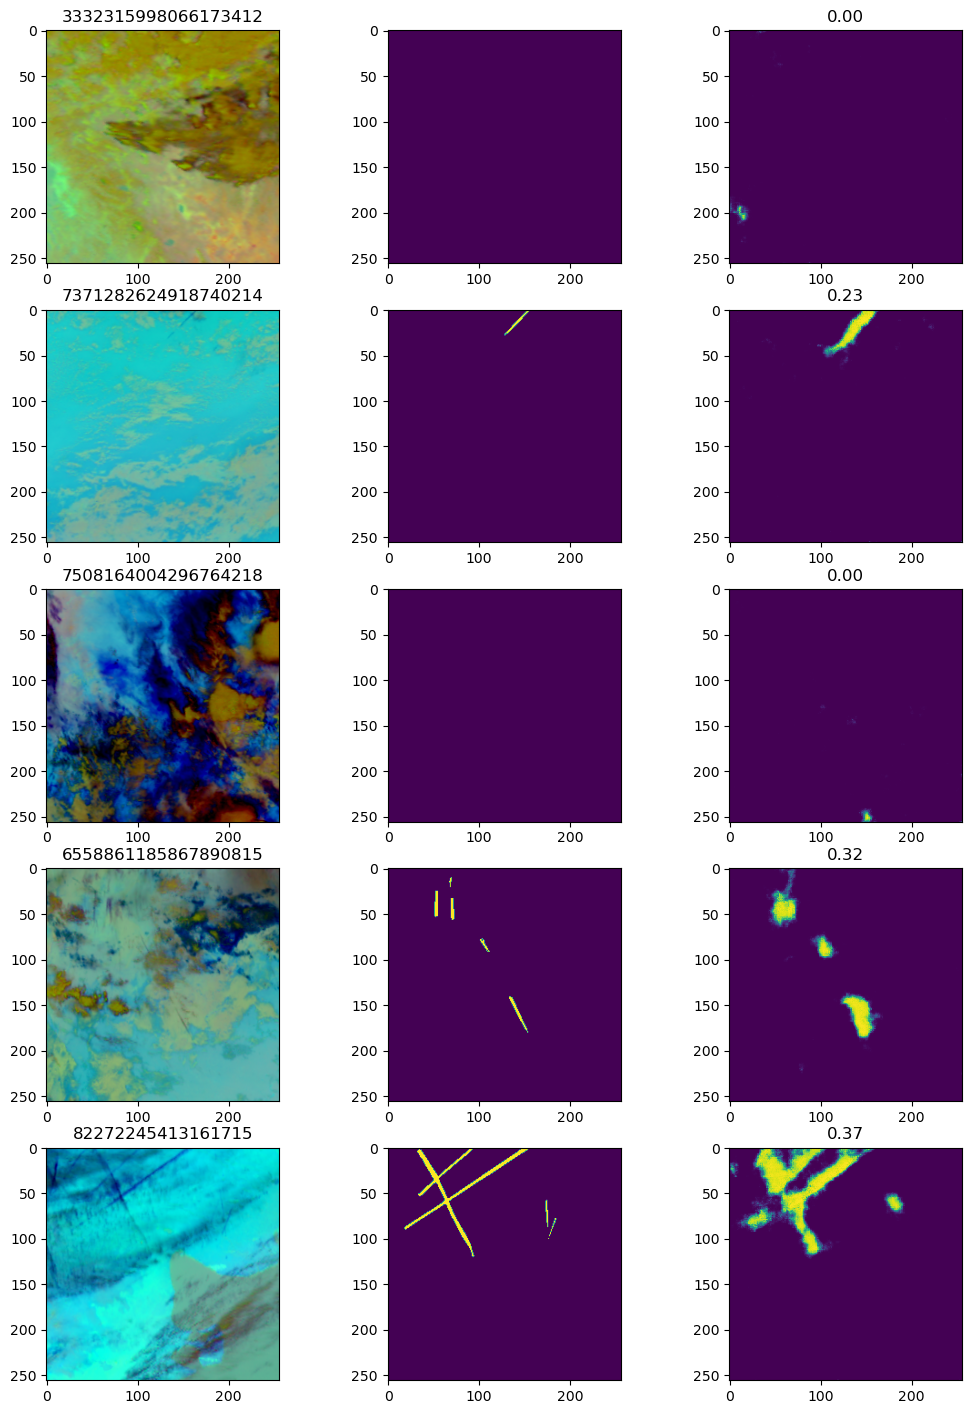

In [39]:
def get_prediction_mask(image):
    """
    Gets the prediction mask given a numpy input image.
    :param image: 
    :return: 
    """
    # Transform image to a tensor with a singleton batch dimension...
    # Transpose so that it is channels first
    input_tensor = torch.from_numpy(image.transpose((2, 0, 1))).unsqueeze(dim=0).to(DEVICE)
    # Pass it through model, and apply sigmoid, so that each pixel 
    # has probability between 0 and 1, and get rid of the singleton dimensions,
    # and convert back to a numpy array
    output = model(input_tensor).sigmoid().squeeze().detach().cpu().numpy()
    # Anything above 0.5 is a contrail, anything below is not
    # output[output >= 0.5] = 1
    # output[output < 0.5] = 0
    # return output.astype(int)
    return output

def plot_contrail_predictions(sample_ids: list):
    # We'll use our plot function defined at the top to create a 5 x 3 grid.
    # Each row will be each sample, showing the original false color image,
    # the mask, and the corresponding prediction, along with labeling the dice score.
    num_ids = len(sample_ids)
    plt.figure(figsize=(9, 3 * num_ids))
    for sample_id, i in zip(sample_ids, range(1, num_ids + 1)):
        image, mask = get_contrail_image_mask(sample_id)
        # Get prediction mask for this input
        prediction = get_prediction_mask(image)
        dice_value = dice(torch.from_numpy(prediction), torch.from_numpy(mask)).item()
        # Plot all 3 in turn
        ax = plt.subplot(num_ids, 3, 3 * i - 2)
        ax.imshow(image)
        ax.set_title(label=sample_id)
        ax = plt.subplot(num_ids, 3, 3 * i - 1)
        ax.imshow(mask)
        ax = plt.subplot(num_ids, 3, 3 * i)
        ax.imshow(prediction)
        ax.set_title(label=f'{dice_value:.2f}')
    plt.subplots_adjust(bottom=0, right=1.2, top=0.9)
    plt.show()

chosen_train_files = ['3332315998066173412', '7371282624918740214', '7508164004296764218', 
                      '6558861185867890815', '82272245413161715']
model.train()
plot_contrail_predictions(chosen_train_files)

#### Validation Images
What would be more interesting are those used for validation.

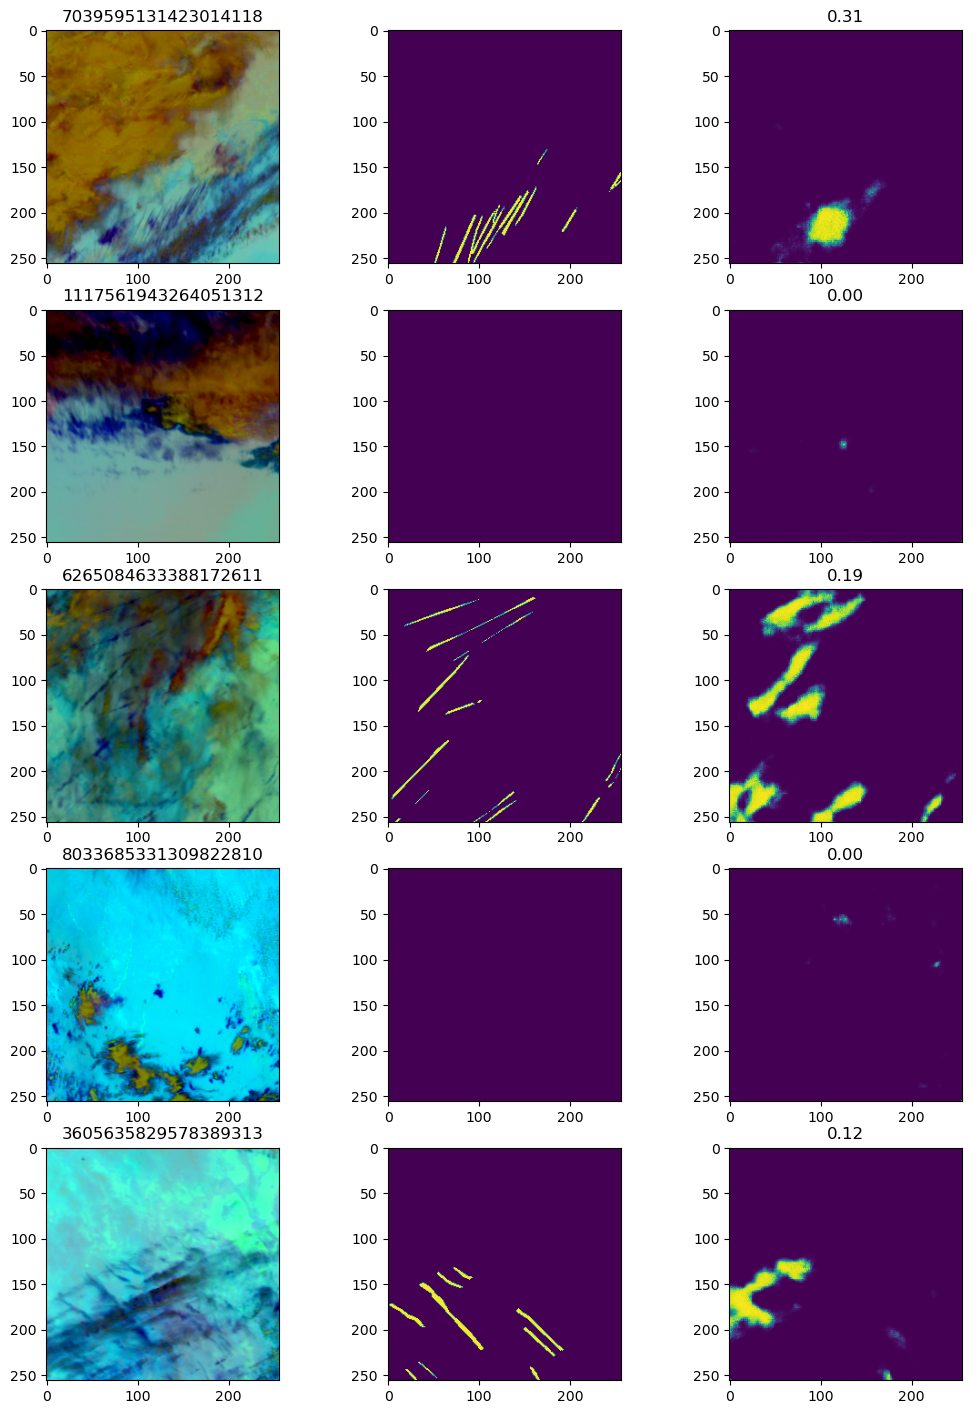

In [38]:
chosen_val_files = ['7039595131423014118', '1117561943264051312', '6265084633388172611', 
                    '8033685331309822810', '3605635829578389313']
model.eval()
plot_contrail_predictions(chosen_val_files)

### Weaknesses
As you can see from the image plots, although there is predictive power in using the UNet, it is struggling with the very linear nature of the contrail. As it is defined, the UNet will do much better in "blob" structures, such as predicting the body of a dog or other images with 2D substance. A very linear segment will prove difficult. Much research has gone into this topic of doing segmentation for linear features. For example, a linear feature which has real application are road lines and markers. An autonomous vehicle system is required to accurately detect the location of road demarcations, in order to stay in lane.

A model which takes a completely different approach is the [EL-GAN](https://arxiv.org/abs/1806.05525). The application of this model is to detect road lanes, which are very linear in structure. They use a general adversarial network to essentially estimate the loss function given the embeddings of both the predictions and the ground truth images at the same time. This results in more stable training runs, and better performance. Of course, this model is a step-up in complexity compared to the UNet we showed in this post.

## Conclusion
Regardless of the shortcomings, this is a fantastic first attempt, as we showed a full definition of UNet using a MobileNet backend in PyTorch. Additionally, we wrapped all functionality within PyTorch Lightning for simplistic training and fitting. We got satisfactory results using many epochs using the Dice coefficient as opposed to accuracy. 

One direct improvement we can make is to recall the heavy class imbalance of the dataset. Above, we showed that approximately 70% of images contain **no contrails at all.** That means it is feasible for us to build a two-stage model. The first stage is a traditional binary classification on the **image itself**. The model will read in an image and determine whether there are contrails anywhere on the image. If yes, then the image is passed on the second stage, which will be the usual UNet model we defined here. If no, then the corresponding image will be a negative pixel for the whole image. The benefit of this approach is that it will **minimize false positives.** We do not want to predict the presence of a contrail when there isn't any. Theoretically, this simple addition should improve the predictive power of the whole system.